# Imports

In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import random
import itertools


from shutil import copyfile, rmtree
from pathlib import Path


from glob import glob

import os
# for dirname, _, filenames in os.walk('/kaggle/input/facial-age/face_age'):
#     print (dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix


In [3]:

INPUT_CLASSES_DIR = '/kaggle/input/facial-age/face_age/'

folders = glob(INPUT_CLASSES_DIR + '*')

ages_dict = {}

for dirname in folders:
    ages_dict[dirname.rsplit('/')[-1]] = len(os.listdir(dirname))

print ('Possible ages:')
ages_dict = dict(sorted(ages_dict.items()))
del[ages_dict['face_age']]

Possible ages:


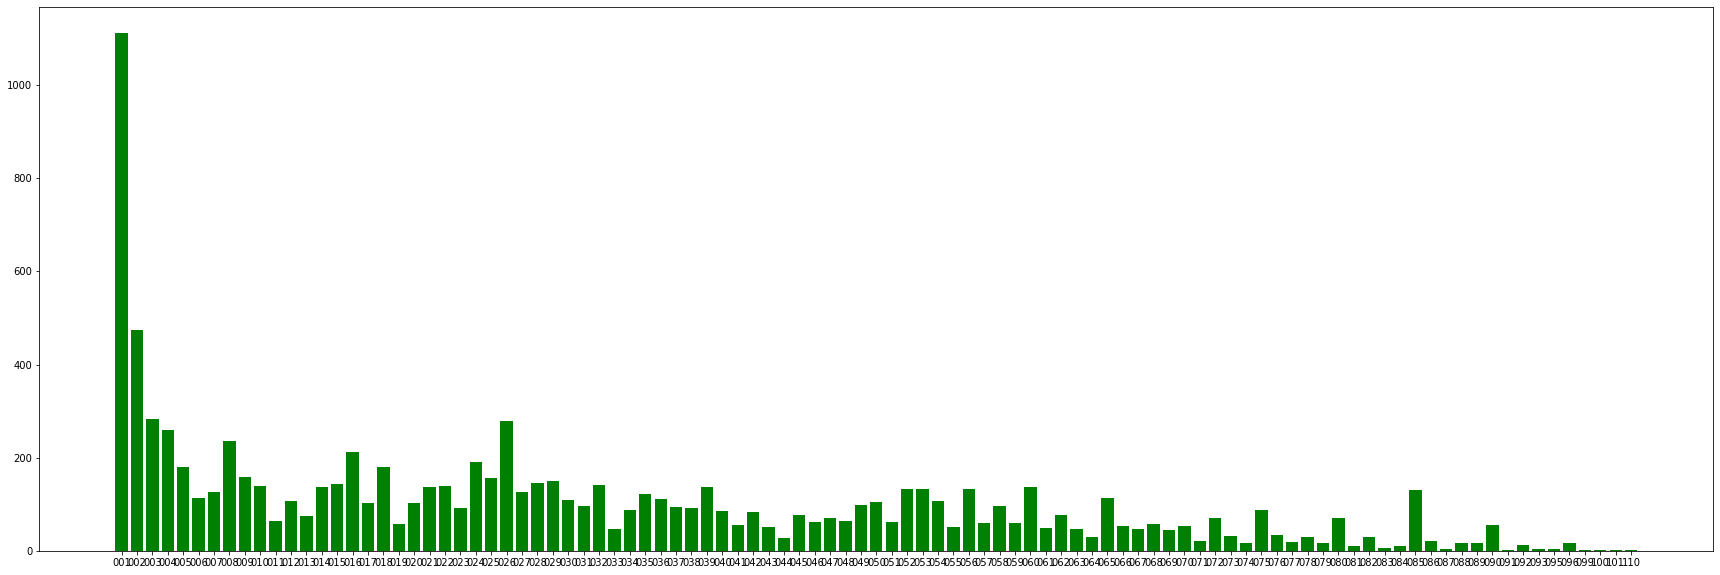

In [4]:
plt.figure(figsize=(30, 10))

plt.bar(list(ages_dict.keys()), ages_dict.values(), color='g')

plt.show()


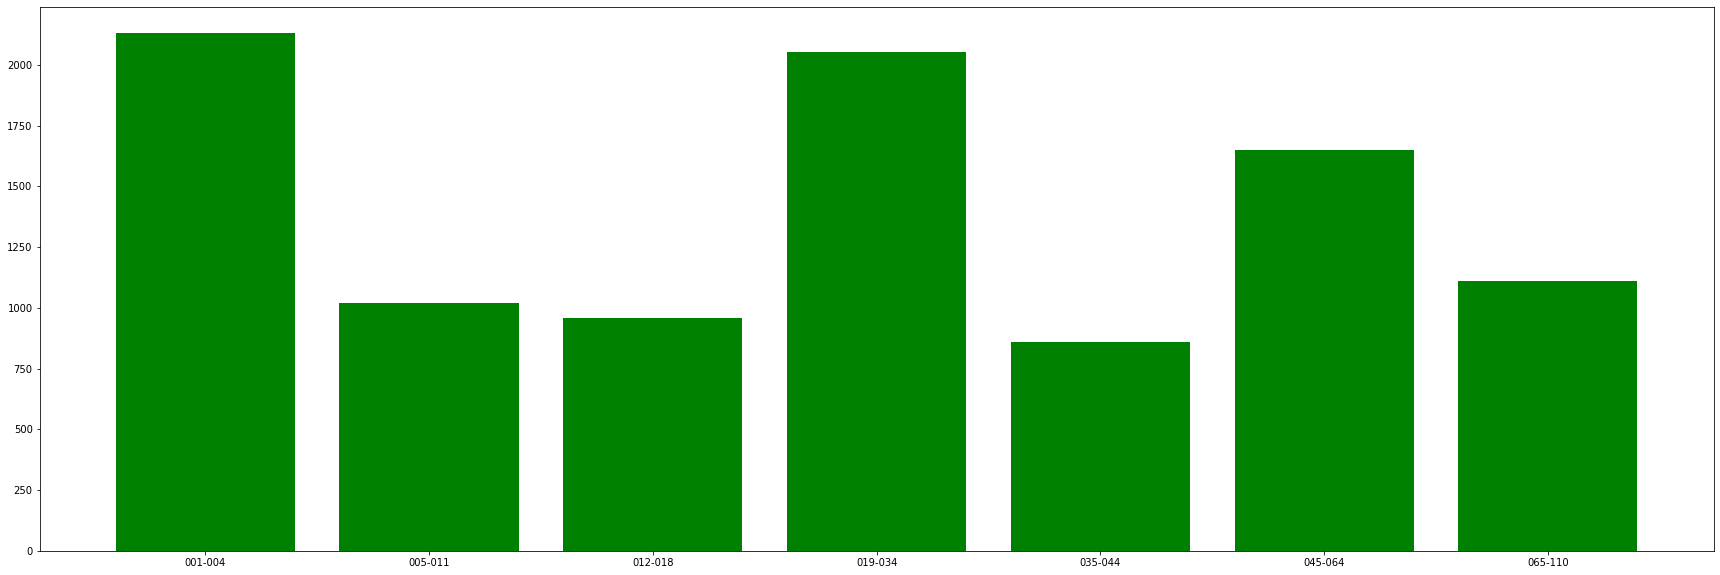

In [102]:
age_splits = [1,5,12,19,35,45,65,111]

age_splits_ranges = [[str(x).rjust(3,"0") for x in list(range(age_splits[idx],age_splits[idx+1]))] for idx in range(len(age_splits)-1)]


age_groups = {}

for age_range in age_splits_ranges:
    total = 0
    for age in age_range:
        if age in ages_dict:
            total += ages_dict[age]
    age_groups[f'{age_range[0]}-{age_range[-1]}'] = total
    
#age_groups
plt.figure(figsize=(30, 10))

plt.bar(list(age_groups.keys()), age_groups.values(), color='g')

plt.show()


In [ ]:
age_groups

In [103]:
MIN_COUNT_IN_CLASS = min(age_groups.values())
MIN_COUNT_IN_CLASS = 40
TRAIN_SAMPLE_SIZE = int(MIN_COUNT_IN_CLASS * 0.85 )
TEST_SAMPLE_SIZE = MIN_COUNT_IN_CLASS - TRAIN_SAMPLE_SIZE

In [87]:
test_root = './test'
train_root = './train'

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

age_groupped_filenames_dict = {}

for age_range in age_splits_ranges:
    Path(f"{test_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    age_groupped_filenames = []
    for age in age_range:
        full_dirname = INPUT_CLASSES_DIR + age
        age_groupped_filenames.extend(glob(full_dirname + '/*'))
    age_groupped_filenames_dict[f'{age_range[0]}-{age_range[-1]}'] = age_groupped_filenames
    
for age_range in age_groupped_filenames_dict:
    age_sample = random.sample(age_groupped_filenames_dict[age_range], MIN_COUNT_IN_CLASS)
    train_filenames = age_sample[:TRAIN_SAMPLE_SIZE]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{age_range}/{f.split('/')[-1]}")
        
    
    test_filenames = age_sample[TRAIN_SAMPLE_SIZE:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{age_range}/{f.split('/')[-1]}")

In [88]:
# useful for getting number of files
train_files = glob(train_root + '/*/*.png')
test_files = glob(test_root + '/*/*.png')


In [89]:
print(len(train_files))
print(len(test_files))


4624
816


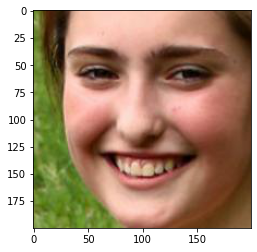

In [90]:
plt.imshow(image.load_img(np.random.choice(train_files)))

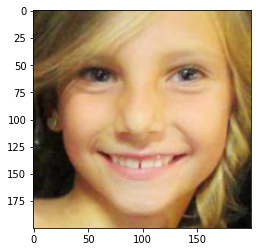

In [33]:
plt.imshow(image.load_img(np.random.choice(test_files)))


In [94]:
# re-size all the images to this
IMAGE_SIZE = [100, 100]

# training config:
epochs = 20
batch_size = 128


# resnet base
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
loss='sparse_categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [37]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [92]:
# get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(test_root, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 816 images belonging to 8 classes.
{'001-003': 0, '004-008': 1, '009-014': 2, '015-019': 3, '020-034': 4, '035-044': 5, '045-064': 6, '065-110': 7}


In [93]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_root,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  test_root,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 4624 images belonging to 8 classes.
Found 816 images belonging to 8 classes.


In [95]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

Epoch 1/20
36/36 [==============================] - 27s 681ms/step - loss: 5.0445 - accuracy: 0.3243 - val_loss: 2.8337 - val_accuracy: 0.3815
Epoch 2/20
36/36 [==============================] - 23s 640ms/step - loss: 2.8720 - accuracy: 0.4175 - val_loss: 2.5620 - val_accuracy: 0.4336
Epoch 3/20
36/36 [==============================] - 23s 637ms/step - loss: 2.7007 - accuracy: 0.4433 - val_loss: 3.0392 - val_accuracy: 0.3906
Epoch 4/20
36/36 [==============================] - 23s 630ms/step - loss: 2.8614 - accuracy: 0.4455 - val_loss: 2.8255 - val_accuracy: 0.3919
Epoch 5/20
36/36 [==============================] - 23s 635ms/step - loss: 2.5577 - accuracy: 0.4684 - val_loss: 4.0760 - val_accuracy: 0.3659
Epoch 6/20
36/36 [==============================] - 22s 624ms/step - loss: 2.6722 - accuracy: 0.4791 - val_loss: 2.8489 - val_accuracy: 0.4427
Epoch 7/20
36/36 [==============================] - 23s 645ms/step - loss: 2.6803 - accuracy: 0.4904 - val_loss: 3.0358 - val_accuracy: 0.4232

In [96]:
cm = get_confusion_matrix(train_root, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(test_root, len(test_files))
print(valid_cm)

Generating confusion matrix 4624
Found 4624 images belonging to 8 classes.
[[434 114  10   5   1   3   9   2]
 [ 17 304  89  56  18  20  68   6]
 [  1  46 297 109  14  29  74   8]
 [  0  12  33 353  43  35  95   7]
 [  1   8  13 112 138 138 161   7]
 [  0   0   2  23   8 326 202  17]
 [  0   1   1  10   6  64 399  97]
 [  0   1   2   5   1  11 102 456]]
Generating confusion matrix 816
Found 816 images belonging to 8 classes.
[[71 22  5  1  1  1  1  0]
 [ 8 33 36 11  2  7  5  0]
 [ 0 13 30 29  2  8 19  1]
 [ 0  4 13 41  7  9 25  3]
 [ 0  4  4 23 14 25 28  4]
 [ 0  1  1  6  3 46 42  3]
 [ 0  0  0  5  2 21 41 33]
 [ 0  0  0  2  0  4 34 62]]


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[434 114  10   5   1   3   9   2]
 [ 17 304  89  56  18  20  68   6]
 [  1  46 297 109  14  29  74   8]
 [  0  12  33 353  43  35  95   7]
 [  1   8  13 112 138 138 161   7]
 [  0   0   2  23   8 326 202  17]
 [  0   1   1  10   6  64 399  97]
 [  0   1   2   5   1  11 102 456]]


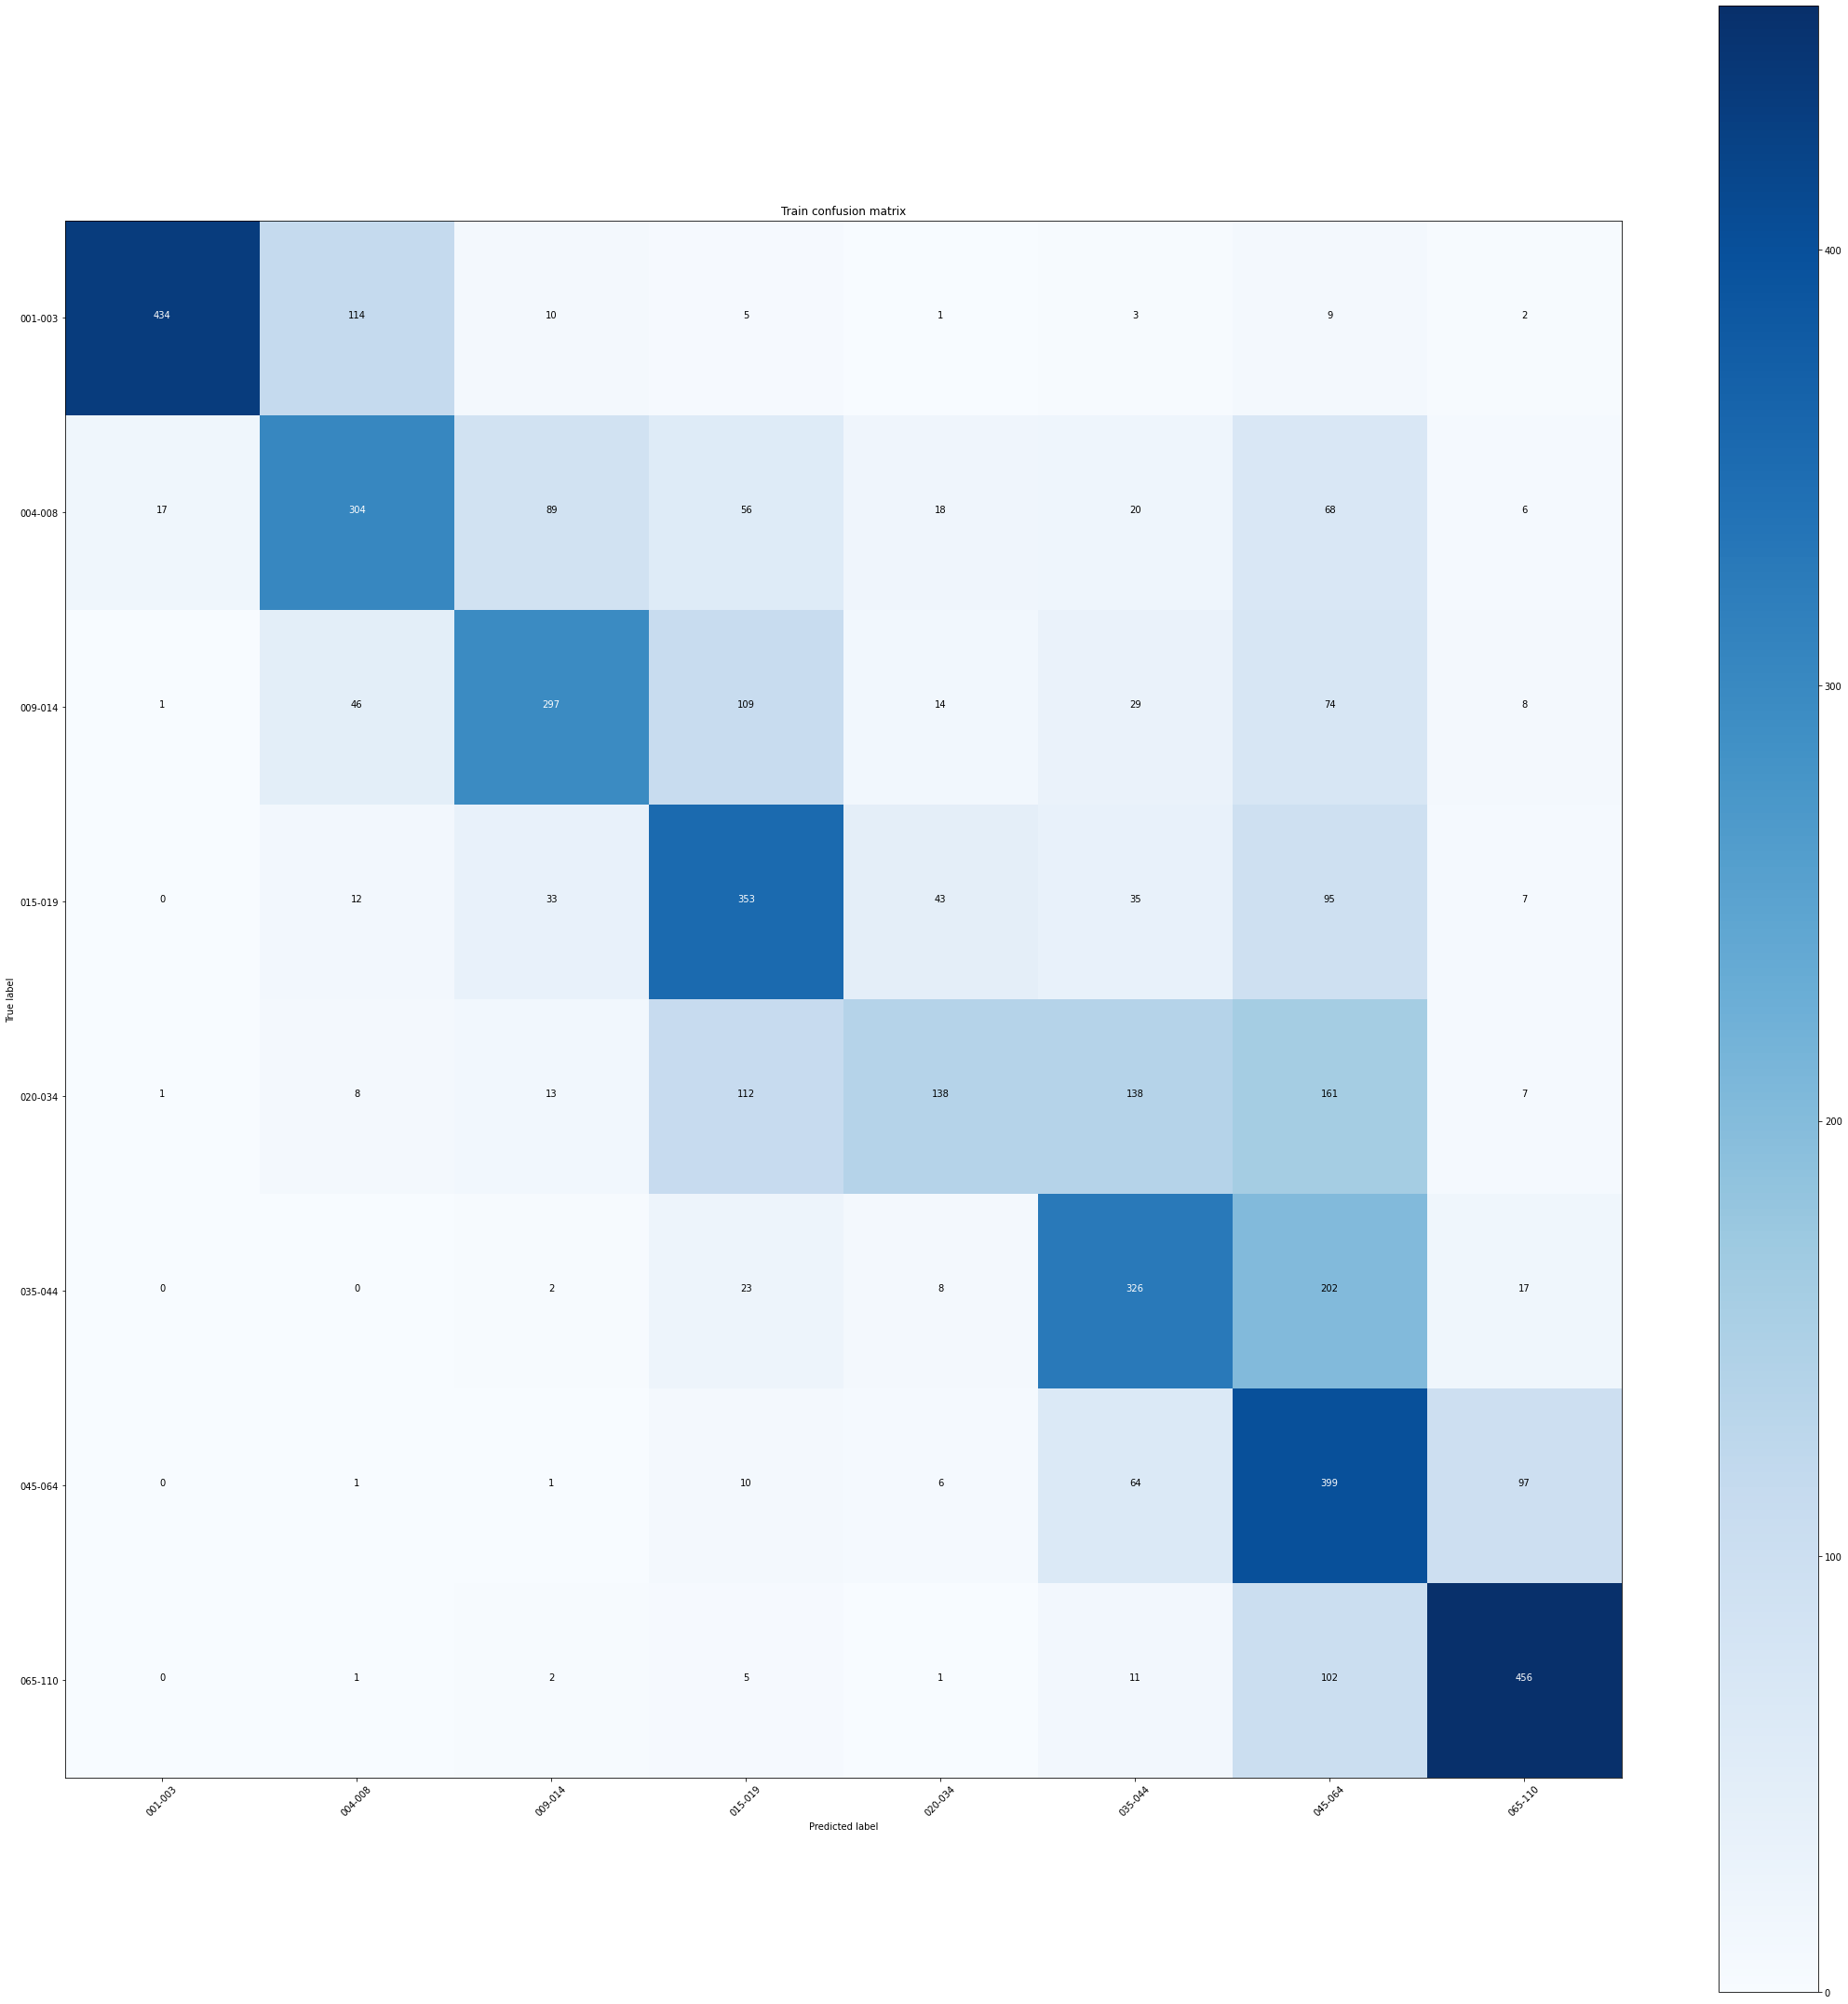

In [97]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')


In [53]:
import requests, io, cv2
import numpy as np
from PIL import Image


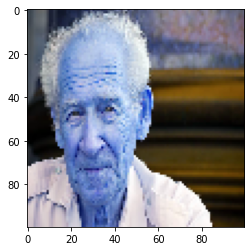

In [100]:
URL = 'https://media.istockphoto.com/photos/cheerful-senior-man-picture-id153011771?k=20&m=153011771&s=612x612&w=0&h=vBUDBf5sjvvgoWn-2aeZaHb6E5iDg-yVBLOa2PruOSk='
response = requests.get(URL)
bytes_im = io.BytesIO(response.content)
cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_RGB2BGR)

internal_image = cv2.resize(cv_im,IMAGE_SIZE)
internal_image = internal_image.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1],3) 


plt.imshow(internal_image[0])

In [101]:
p = model.predict(internal_image)
#p = np.argmax(p)
pred_list = {x : float(y) for x,y in zip(labels, p[0])}
pred_list = dict(sorted(pred_list.items(), reverse=True, key=lambda item: item[1]))
pred_list

{'065-110': 1.0,
 '015-019': 8.120346300759251e-13,
 '045-064': 2.777919767046194e-14,
 '020-034': 4.418160352222959e-19,
 '009-014': 3.5727525563783844e-19,
 '004-008': 1.9846636202333998e-19,
 '001-003': 4.995669421573927e-20,
 '035-044': 5.8226316452428644e-24}